In [49]:
import numpy as np
import nltk
import re

# The first time you will need to download the corpus:
nltk.download('webtext')
nltk.download('punkt')
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

from torchvision.datasets import MNIST
import torchvision.transforms as T

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package webtext to
[nltk_data]     /usr4/ugrad/kyan/nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package punkt to /usr4/ugrad/kyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

Using cuda
True
1
0
Tesla V100-SXM2-16GB


In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

In [2]:
# file_path = "/content/drive/My Drive/J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt"
file_path = "J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt"

In [3]:
with open(file_path, 'r') as file:
    content = file.read()
chapters = content.split('CHAPTER')
chapters = chapters[1:]
def cleaner(chapters):
  text = ((nltk.word_tokenize(chapters)))
  #print(set(cleaned.split(' ')))
  clean_text = [token for token in text if token != "''"]
  clean_text = [token for token in clean_text if token != "``"]
  clean_text = [token for token in clean_text if token != "--"]
  clean_text = [token for token in clean_text if token != "-"]
  clean_text = [token for token in clean_text if token != "..."]
  clean_text = [token for token in clean_text if token != "...."]
  return ' '.join((clean_text))

docs = [cleaner(chapter) for chapter in chapters]

In [4]:
print(len(docs))

17


In [5]:
file_path1 = "J. K. Rowling - Harry Potter 3 - Prisoner of Azkaban.txt"
with open(file_path1, 'r') as file1:
    content = file1.read()
chapters = content.split('CHAPTER')
chapters = chapters[1:]
docs.extend([cleaner(chapter) for chapter in chapters])

In [6]:
print(len(docs))

39


In [7]:
file_path2 = "J. K. Rowling - Harry Potter 4 - The Goblet of Fire.txt"
with open(file_path2, 'r',encoding='utf-8') as file2:
    content = file2.read()
chapters = content.split('CHAPTER')
chapters = chapters[1:]
docs.extend([cleaner(chapter) for chapter in chapters])
print(len(docs))

76


In [8]:
max_len = 0
for chapter in docs:
  tokenized = nltk.word_tokenize(chapter)
  max_len = max(max_len, len(tokenized))
max_len

9842

In [225]:
#!pip install transformers

In [9]:
import os
import time
import datetime
#from google.colab import drive

import pandas as pd
#import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup


In [ ]:
!nvidia-smi

# Create Training Set


Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most lines will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [10]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


In [11]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [12]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [13]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each line in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the line is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the line is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [14]:
dataset = GPT2Dataset(docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   68 training samples
    8 validation samples


In [15]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [16]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [17]:
print(device)

cuda


In [34]:
# some parameters I cooked up that work reasonably well

epochs = 100
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [35]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [36]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [37]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [38]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 100 ========
Training...

  Average training loss: 2.56
  Training epoch took: 0:00:05

Running Validation...
  Validation Loss: 3.73
  Validation took: 0:00:00

======== Epoch 2 / 100 ========
Training...

  Average training loss: 2.44
  Training epoch took: 0:00:05

Running Validation...
  Validation Loss: 3.94
  Validation took: 0:00:00

======== Epoch 3 / 100 ========
Training...

  Average training loss: 2.17
  Training epoch took: 0:00:05

Running Validation...
  Validation Loss: 4.08
  Validation took: 0:00:00

======== Epoch 4 / 100 ========
Training...

  Average training loss: 1.80
  Training epoch took: 0:00:05

Running Validation...
  Validation Loss: 4.47
  Validation took: 0:00:00

======== Epoch 5 / 100 ========
Training...

  Average training loss: 1.37
  Training epoch took: 0:00:05

Running Validation...
  Validation Loss: 4.74
  Validation took: 0:00:00

======== Epoch 6 / 100 ========
Training...

  Average training loss: 0.99
  Training epoch to

In [39]:
def generate_multiple_text(prompt, number_of_iterations):
    model.eval()
    generated_text = ""
    for _ in range(number_of_iterations):
        print()
        generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to(device)
        sample_outputs = model.generate(
            generated,
            do_sample=True,
            top_k=50,
            max_length=1000,
            top_p=0.95,
            num_return_sequences=1
        )
        # Get the generated text from the first sequence output
        generated_text += tokenizer.decode(sample_outputs[0], skip_special_tokens=True)
        prompt = generated_text[-100:]  # Update the prompt for the next iteration
    return generated_text


In [41]:
# Example of prompt
prompt = "Voldemort is Harry"
generated_text = generate_multiple_text(prompt, number_of_iterations=8)  # Change the number as needed
generated_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Voldemort is Harry's friend. Even though he could see past his numb disbelief, he couldn't help it ; he felt as though he 'd lost one of his best friends. He had a stream of visitors, all intent on cheering him up. Hagrid sent him a bunch of earwiggy flowers that looked like yellow cabbages, and Ginny Weasley, blushing furiously, turned up with a get-well card she had made herself, which sang shrilly unless Harry kept it shut under his bowl of fruit. The Gryffindor team visited again on Sunday morning, this time accompanied by Wood, who told Harry ( in a hollow, dead sort of voice ) that he didn't blame him in the slightest. Ron and Hermione left Harry's bedside only at night- But nothing anyone said or did could make Harry feel any better, because they knew only half of what was troubling him. He hadn't told anyone about the Grim, not even Ron -and Hermione, because he knew Ron would panic and Hermione would scoff. The fact remained, however, that it had now appeared twice, and both 

In [44]:
print(len(docs))

76


In [ ]:
generated_text

In [ ]:
print(docs)

In [51]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from collections import Counter

In [77]:
docs1 = [nltk.word_tokenize(doc) for doc in docs]

In [86]:
flattened_list = [item for chapter in docs1 for item in chapter]

In [94]:
glove_input_file = '/projectnb/cs505ws/students/kyan/glove.6B.200d.txt'
word2vec_output_file = 'glove.6B.200d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

/scratch/3107329.1.academic-gpu/ipykernel_309486/990905266.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 200)

In [95]:
filename = 'glove.6B.200d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [102]:
sorted_vocab = sorted(list(set(flattened_list)))

In [103]:
# Create Vocabulary and Word Vectors
word_to_idx = {}
idx_to_word = {}
for i,token in enumerate(sorted_vocab):
    if token not in word_to_idx:
        word_to_idx[token] = i
        idx_to_word[i] = token

In [ ]:
#vocabulary size
V = len(word_to_idx) + 1
print("Vocabulary size:", V)
print(f'There are {len(sorted_vocab)} characters in the text.')
print(f'Character set: {sorted_vocab}.')

In [104]:
embedding_dim = 200
embedding_matrix = np.zeros((V,embedding_dim))
for word, i in word_to_idx.items():
    if word in model:
        embedding_matrix[i] = model[word]
    else:
        embedding_matrix[i] = np.random.rand(200)
        
print(embedding_matrix.shape)

(16594, 200)


In [ ]:
print(word_to_idx)


In [ ]:
print(idx_to_word)

In [ ]:
encoded_sequences = [word_to_idx[word] for word in flattened_list]
print(len(encoded_sequences),encoded_sequences)
# Convert embedding_matrix to torch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
print(embedding_matrix,embedding_matrix.shape)

In [109]:
class LSTMDataset(Dataset):
    def __init__(self, encoded_sequences, sequence_length):
        self.sequences = encoded_sequences
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.sequences) - self.sequence_length

    def __getitem__(self, idx):
        # Get a sequence of tokens and the token next to it as the target
        input_seq = self.sequences[idx:idx + self.sequence_length]
        target = self.sequences[idx + self.sequence_length]
        return torch.tensor(input_seq), torch.tensor(target)

In [110]:
# Create an instance of LSTMDataset with a max sample length of 50
sample_length = 50
lstm_dataset = LSTMDataset(encoded_sequences, sample_length)

In [111]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim,hidden_dim,embedding_matrix):
        super(LSTMModel,self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim,vocab_size)
    def forward(self,x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])
        return output

In [112]:
embedding_dim = 200
hidden_dim = 256
batch_size = 64
lstm_loader = DataLoader(lstm_dataset, batch_size=batch_size, shuffle=True)
model = LSTMModel(V,embedding_dim,hidden_dim,embedding_matrix)

print(model)
print(torch.cuda.get_device_name(0))
model = model.double().to(device)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
# Define Loss, Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 0

LSTMModel(
  (embedding): Embedding(16594, 200)
  (lstm): LSTM(200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=16594, bias=True)
)
Tesla V100-SXM2-16GB
GPU is available


100%|██████████| 100/100 [1:33:10<00:00, 55.90s/it]


Finished Training


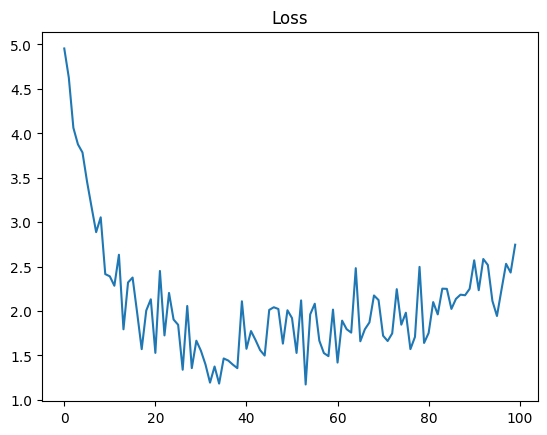

In [113]:
# Training loop
losses = []
num_epochs = 100  # Define the number of epochs
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for data in (lstm_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
plt.title('Loss')
plt.plot(losses)
print('Finished Training')

In [115]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in tqdm(lstm_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the highest probability class
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the training set: {accuracy:.2f}%')


100%|██████████| 7005/7005 [00:22<00:00, 304.78it/s]

Accuracy on the training set: 49.90%


In [117]:
def generate_sentence(model,prompt,word_to_idx,idx_to_word,max_length=50,temperature=1.0,length=5000):
    model.eval()
    i=0
    with torch.no_grad():
        current_text = prompt.split()
        while i < 5000:
            input_indices = [word_to_idx[word] for word in current_text]
            input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)
            predictions = model(input_tensor)
            probabilities = torch.softmax(predictions[0,:]/temperature,dim=-1)
            #Sample a word based on the probabilities
            next_word_idx = torch.multinomial(probabilities,1).item()
            next_word = idx_to_word[next_word_idx]
            i += 1
            
            current_text.append(next_word)
        # current_text.append(".")    
        generated_sentence = ' '.join(current_text)
        return generated_sentence

In [ ]:
seed_text  = 'Harry Potter'
gen_sentence = generate_sentence(model,seed_text,word_to_idx,idx_to_word)
print(gen_sentence,(len(gen_sentence.split())))

In [125]:
gen_sentence

"Harry Potter heap upright though they were standing behind her collar , staring down at the swirling white mist before Ludo Bagman in the doorway . Amos Diggory , what 's fingers ? The other two clunking bottle into fireworks Mmm ! said Ron as she spotted Harry 's trolley and put his broom out of the way , staring at his watch . From what I had the right person in here he 'd just swallowed a couple of hours ? It 's very easy , had grown at birthday morning and try . Hagrid was right Ron . He was looking at Harry , Ron , and Hermione 's sounded shrill voice echoing across his head . Mom , now , please . Ha haaa and Told us only when Slytherin is a little time for Christmas ! I did n't give it , said Harry . at all they 'd emerged looking up to the kitchens . Harry 's eyes filled with tears a sudden burst out of its wits . It 's the best if we ever had been his face He stole livid tonight . This is one of the dog ! Quirrell 's , he said in a muffled squeak . No one , said Lupin . Our ex